# YouTube Data API v3 - Mapping Corridor Digital's Network

### Python Libraries

In [1]:
import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

## Custom modules

In [2]:
#import config # api_key is stored in config.py
import youtube_requests # Functions for making youtube_requests
import data_processing # Functions for data processing    
import network_graphs # Functions for creating a network graph

Run autoloader to automatically reimport custom modules

In [3]:
%load_ext autoreload

%autoreload 1

%aimport network_graphs
%aimport youtube_requests
%aimport data_processing

## Create a list of channels to graph network

Here we are graphing Corridor, Corridor Crew, Corridor Cast, Node, and the Guilletine Channel. These are all channels related to the [Corridor Digital](https://www.youtube.com/user/CorridorDigital) production studio.

In [4]:
NBC_AND_FOX = ['UCeY0bbntWzzVIaj2z3QigXg', # NBC
              'UCXIJgqnII2ZOINSWNOGFThA'] # Fox

In [5]:
CORRIDOR_FIVE = ['UCNSeDrWRGxx5p2l3tj7RWQw',
                'UCsn6cjffsvyOZCZxvGoJxGg',
                'UCSpFnDQr88xCZ80N-X7t0nQ',
                'UCI4Wh0EQPjGx2jJLjmTsFBQ',
                'UCb8ewylk7d2M_1dLGEiFmuQ']

# Youtube Channel Details by Network

In [6]:
%%time
# Get a list of dictionaries, where each dictionary represents details for a specific channel
CHANNELS_DETAILS_ITEMS_LIST = youtube_requests.youtube_channel_details_by_network(NBC_AND_FOX, 3)

# Graph the network of channels
G = network_graphs.create_nx_graph(CHANNELS_DETAILS_ITEMS_LIST, True)

# Extract a columnar list of channel details
CHANNELS_DETAILS_LIST = data_processing.extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Create a dataframe
DF = data_processing.create_df_from_details_list(CHANNELS_DETAILS_LIST)

# Graph G using matplotlib - gets messy with lots of data
#network_graphs.graph_nx_graph(G)

Channel_details_by_network
Have not seen this list, issuing request and caching.
2
13 total neighbors; 0 out of 2 channels do not feature channels
13
71 total neighbors; 2 out of 13 channels do not feature channels
50
59
137 total neighbors; 0 out of 59 channels do not feature channels
50
86
Time elapsed create graph:  0.004084999999999894
Time elapsed channelId list:  9.999999999976694e-05
Time elapsed determine position:  2.655359
Time elapsed Setting Attributes:  0.0015910000000003421
CPU times: user 3.01 s, sys: 220 ms, total: 3.23 s
Wall time: 18 s


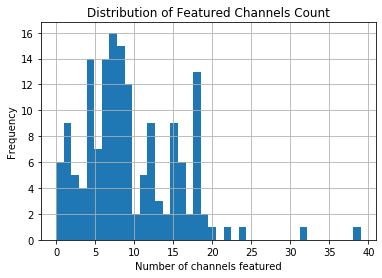

In [8]:
DF.hist(column='outDegree', bins=40)
plt.title(label='Distribution of Featured Channels Count')
plt.xlabel(xlabel='Number of channels featured')
plt.ylabel(ylabel='Frequency');

Here we see most channels do not feature more than 10 other channels on their profile pages. Some feature a lot more, with one as an outlier featuring 40 other channels.

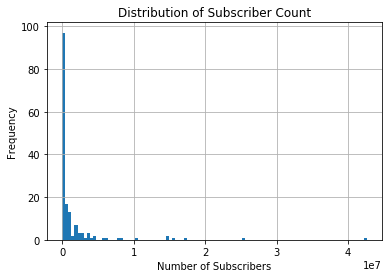

In [9]:
DF.hist(column = 'subscribers', bins=100)
plt.title(label='Distribution of Subscriber Count')
plt.xlabel(xlabel='Number of Subscribers')
plt.ylabel(ylabel='Frequency');

Here we see that the distribution of subscriber counts for each channel is not limited to highly subscribed channels. In fact there are a lot of channels with less than 100k subscribers.

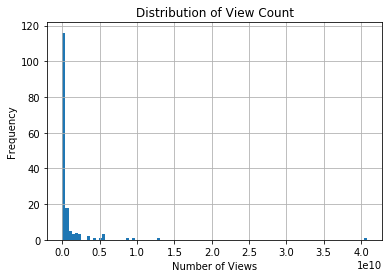

In [10]:
DF.hist(column = 'views', bins=100)
plt.title(label='Distribution of View Count')
plt.xlabel(xlabel='Number of Views')
plt.ylabel(ylabel='Frequency');

Here we see the same thing as with subscriber count; there are a lot of channels that do not have a lot of views, even though we are coming from a network that has some channels that have over 1 billion views.

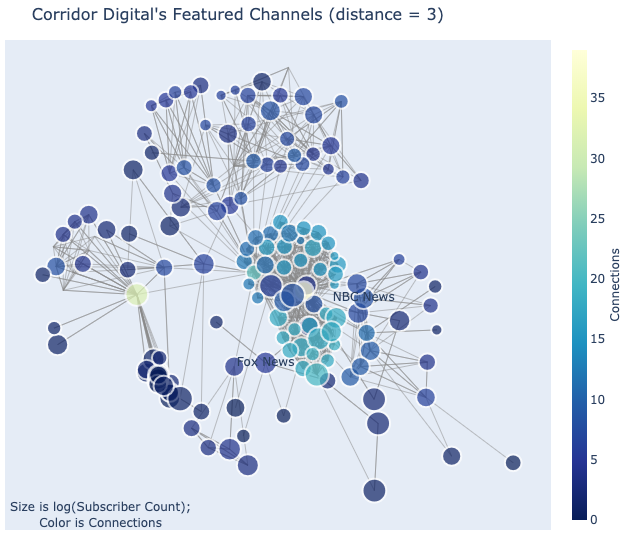

In [11]:
fig = network_graphs.plotly_network_graph(G, "Connections", "Corridor Digital's Featured Channels (distance = 3)")
fig # Interactive version of the figure for notebooks

Here we see Corridor Digital's network at a distance of 3 or less away. The colors represent the number of outgoing connections from each node. Those with high values (yellow) feature more channels than those with lower values (blue).

In [34]:
fig.write_html("./images/strong-corridor-3.html")

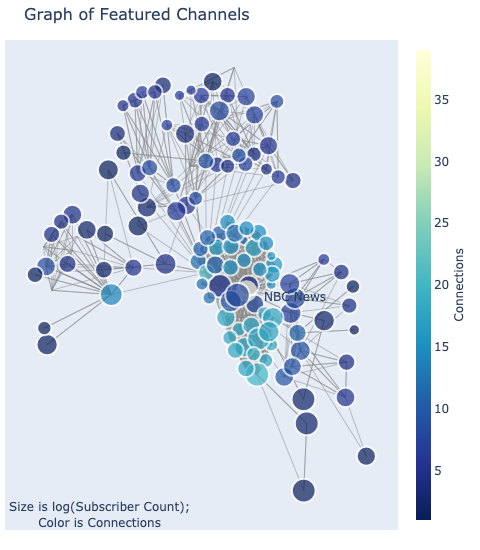

In [33]:
fig

In [36]:
fig.write_image('images/nbcfox-3.png')

In [ ]:
fig.show("png")

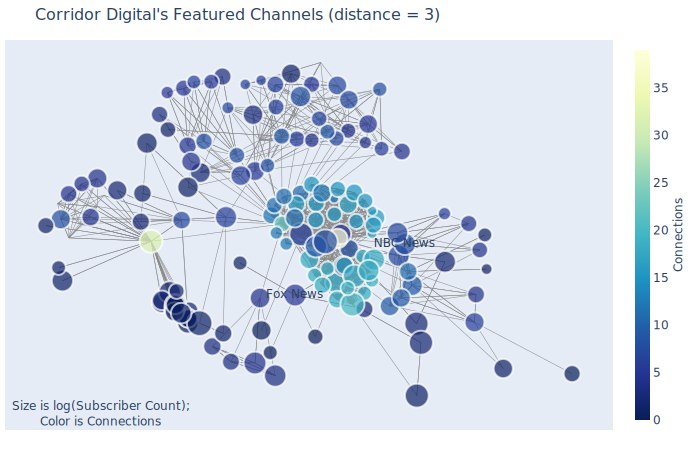

In [12]:
# Show figure for GitHub
fig.show("svg")

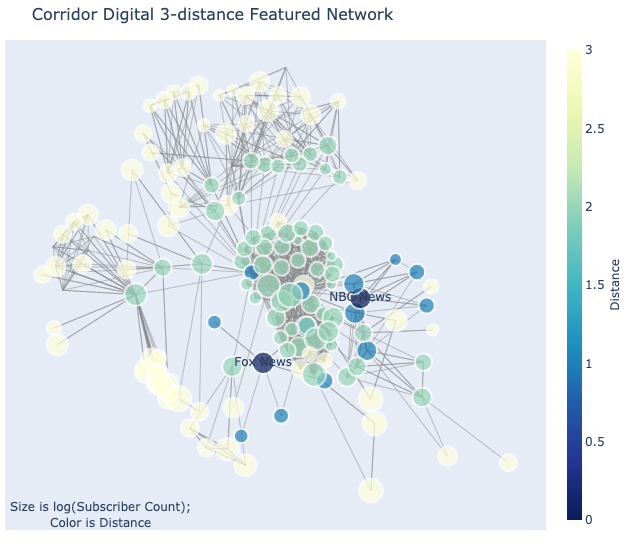

In [13]:
fig = network_graphs.plotly_network_graph(G, 
                              color_setting="Distance", 
                              title='Corridor Digital 3-distance Featured Network')
fig

Here we again see Corridor Digital's network at a distance of 3 or less. In this case the colors represent the distance from our channel origins. Blue represents origin, ligh blue represents 1 channels away, green represents 2 channels away, and yellow represents 3 channels away.

It could be possible for a channel that is 3 channels away from Corridor Digital to then reference one of the Corridor channels back, but this would not change their distance, as going *from* a Corridor Channel *to* that other channel, required three steps to crawl to that channel. Directionality in this case matters.

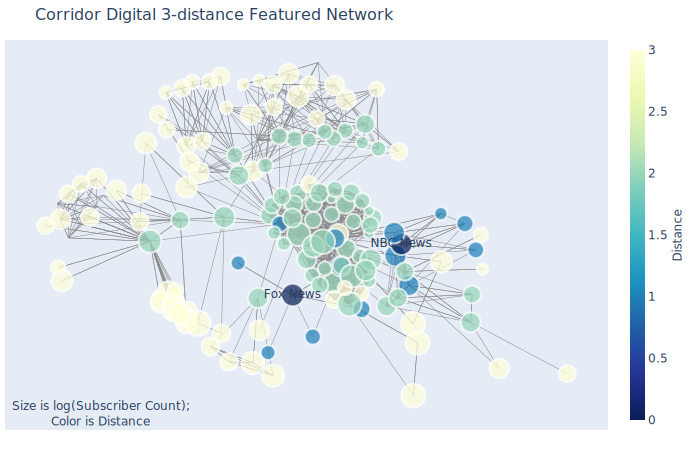

In [14]:
# Show figure for GitHub
fig.show("svg")

## Page Rank, In-Degree centrality, Betweeness Centrality, and In-Degree value

In [15]:
page_rank_series = pd.Series(data = network_graphs.simple_page_rank(G), index = list(G.nodes().keys()))
DF['page_rank'] = DF['id'].map(lambda x:page_rank_series[x])

betweenness_dict = nx.betweenness_centrality(G)
DF['betweenness_centrality'] = DF['id'].map(lambda x:betweenness_dict[x])

in_degree_centrality_dict = nx.in_degree_centrality(G)
DF['in_degree_centrality'] = DF['id'].map(lambda x:in_degree_centrality_dict[x])

in_degree_dict = {node:G.in_degree()[node] for node in G.nodes()}
DF['in_degree'] = DF['id'].map(lambda x:in_degree_dict[x])

degree_dict = {node:G.degree()[node] for node in G.nodes()}
DF['degree'] = DF['id'].map(lambda x:degree_dict[x])

FEATURES = ['title','outDegree','degree','in_degree','betweenness_centrality','in_degree_centrality','page_rank','subscribers','views','id']

### Sort channels by page rank

Page rank is a relative measure of importance for a specific channel with the network. 

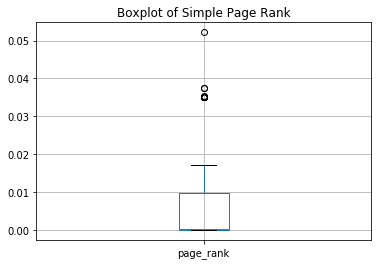

In [16]:
DF.boxplot(column='page_rank')
plt.title("Boxplot of Simple Page Rank");

In [17]:
DF[FEATURES].sort_values(
    'page_rank', ascending=False).head(8)

title  outDegree  degree  in_degree  \
5                       NBC         39      87         48   
58   Better Late Than Never         19      20          1   
143     Last Comic Standing         19      20          1   
33     America's Got Talent         20      38         18   
43        Jay Leno's Garage         18      34         16   
28                The Voice         18      35         17   
87          Bring The Funny         18      32         14   
21     Hollywood Game Night         18      33         15   

     betweenness_centrality  in_degree_centrality  page_rank  subscribers  \
5                  0.126977              0.301887   0.052177       726000   
58                 0.000450              0.006289   0.037509        12000   
143                0.000418              0.006289   0.037509        19800   
33                 0.023101              0.113208   0.035276     17300000   
43                 0.003175              0.100629   0.035110      2990000   
28                 0.001367              0.106918   0.035110      8180000   
87                 0.000000              0.088050   0.035110        25500   
21                 0.000450              0.094340   0.035110        19000   

          views                        id  
5      62308468  UCccjdJEay2hpb5scz61zY6Q  
58      1051330  UCqfhoZOoNt2ZpsDBnLAAW4Q  
143           0  UCUG6rn3QMETve9cjGLtDLxw  
33   3556551840  UCT2X19JJaJGUN7mrYuImANQ  
43    637878335  UCQMELFlXQL38KPm8kM-4Adg  
28   1205273408  UCpdK1NLHxEUGXc1gq2NxkTw  
87      5822218  UC8m0c5CWRhKjlMMBdLC4HMw  
21      3675979  UCpBkBMO8IbYAMdtYNaMxKgQ

In [18]:
sorted_pgrank_list = list(DF[FEATURES].sort_values(
    'page_rank', ascending=False).head(8)['id'])

Lets take a look at these channels listed on the graph

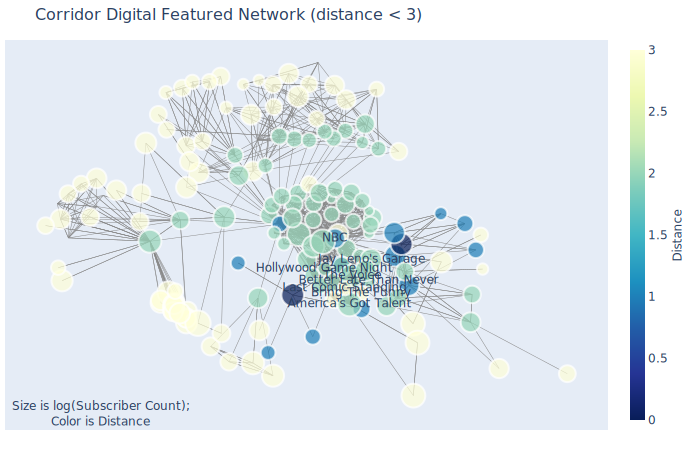

In [19]:
fig = network_graphs.plotly_network_graph(G, 
                              color_setting="Distance", 
                              title='Corridor Digital Featured Network (distance < 3)',
                            display_list=sorted_pgrank_list)
fig
fig.show('svg')

### Sort channels by betweenness centrality.

Betweenness centrality is a measure of connectivity for a node in a network. A higher betweenness centrality implies that the node is a critical pathway for other nodes to connect across the graph.

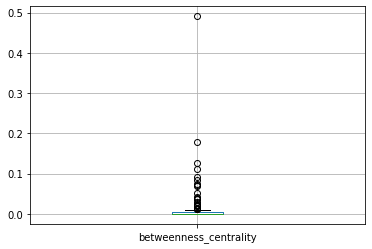

In [20]:
DF.boxplot(column='betweenness_centrality');

In [21]:
DF[FEATURES].sort_values(
    'betweenness_centrality', ascending=False).head(8)

title  outDegree  degree  in_degree  betweenness_centrality  \
12              Peacock         22      82         60                0.490607   
40         Peacock Kids         32      48         16                0.178247   
5                   NBC         39      87         48                0.126977   
26   Universal Pictures          6      11          5                0.112775   
71           Peacock jr          7      15          8                0.091490   
80       Top Chef World          3      25         22                0.083848   
107        Illumination          1       4          3                0.074516   
6                 TODAY          7      17         10                0.071226   

     in_degree_centrality     page_rank  subscribers       views  \
12               0.377358  6.126308e-03        76200    15695752   
40               0.100629  2.097559e-07      7770000  5507662147   
5                0.301887  5.217746e-02       726000    62308468   
26               0.031447  4.245687e-04      3540000  2280177052   
71               0.050314  2.021899e-06       287000   269281238   
80               0.138365  4.585629e-04            0      194897   
107              0.018868  2.900276e-05      2090000  1550127278   
6                0.062893  5.361514e-03      2420000  1696860994   

                           id  
12   UCPgMAS8woHJ_o_OZdTR7kcQ  
40   UCY26xU0-avwTJ6F6TzUZVEw  
5    UCccjdJEay2hpb5scz61zY6Q  
26   UCq0OueAsdxH6b8nyAspwViw  
71   UCKtfozhWfwvXUTnR7PV3t5g  
80   UCzbq2-fIG666CtetQAxiyww  
107  UCq7OHvWO6Z3u-LztFdrcU-g  
6    UChDKyKQ59fYz3JO2fl0Z6sg

In [22]:
sorted_btwn_list = list(DF[FEATURES].sort_values(
    'betweenness_centrality', ascending=False).head(8)['id'])

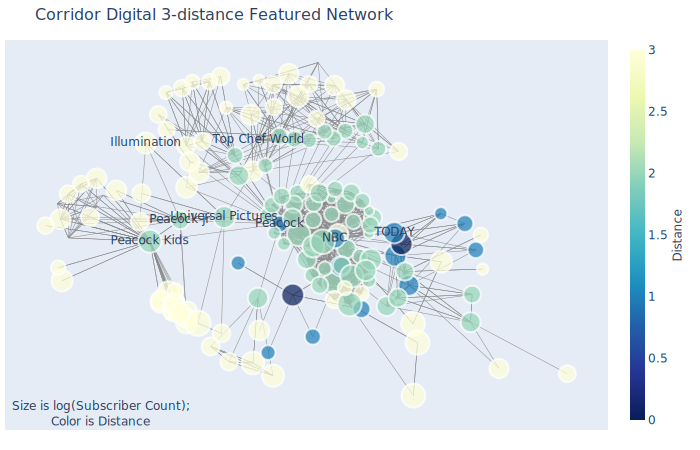

In [23]:
fig = network_graphs.plotly_network_graph(G, 
                              color_setting="Distance", 
                              title='Corridor Digital 3-distance Featured Network',
                            display_list=sorted_btwn_list)
fig
fig.show('svg')

### Sort channels by in_degree centrality.

In degree centrality is a measure of a nodes importance as a reference from other channels. A high in degree centrality value implies that the node is highly referenced by other channels within this network.

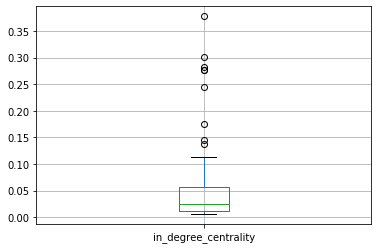

In [24]:
DF.boxplot(column='in_degree_centrality');

In [25]:
DF[FEATURES].sort_values(
    'in_degree_centrality', ascending=False).head(8)

title  outDegree  degree  in_degree  \
12                                  Peacock         22      82         60   
5                                       NBC         39      87         48   
52   The Tonight Show Starring Jimmy Fallon          8      53         45   
31           A Little Late With Lilly Singh          8      52         44   
61              Late Night with Seth Meyers          9      53         44   
103                 The Kelly Clarkson Show          5      43         39   
69                      Saturday Night Live          6      34         28   
34            Zoey's Extraordinary Playlist         15      38         23   

     betweenness_centrality  in_degree_centrality  page_rank  subscribers  \
12                 0.490607              0.377358   0.006126        76200   
5                  0.126977              0.301887   0.052177       726000   
52                 0.015372              0.283019   0.011620     25400000   
31                 0.023208              0.276730   0.006369       470000   
61                 0.015824              0.276730   0.013715      3840000   
103                0.069421              0.245283   0.002515      1150000   
69                 0.009955              0.176101   0.006149     10400000   
34                 0.005249              0.144654   0.015178        86400   

           views                        id  
12      15695752  UCPgMAS8woHJ_o_OZdTR7kcQ  
5       62308468  UCccjdJEay2hpb5scz61zY6Q  
52   12745262486  UC8-Th83bH_thdKZDJCrn88g  
31      56192616  UC2gzy_aI-luPtEpL-GzQP6w  
61    1955922856  UCVTyTA7-g9nopHeHbeuvpRA  
103    165781032  UCmSQ47G2NHhcjRAm9Px6R3g  
69    9432215206  UCqFzWxSCi39LnW1JKFR3efg  
34      17255785  UCafnKR1-5Xd06avwkrEB-fA

Lets also look at the distribution of in degree centrality values.

In [26]:
sorted_indeg_list = list(DF[FEATURES].sort_values(
    'in_degree_centrality', ascending=False).head(8)['id'])

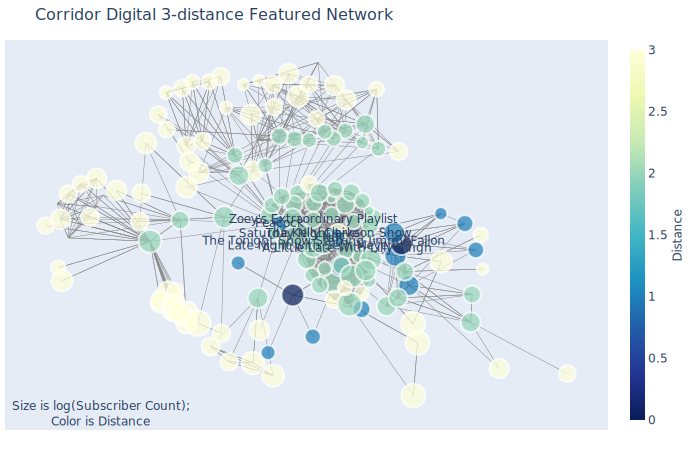

In [27]:
fig = network_graphs.plotly_network_graph(G, 
                              color_setting="Distance", 
                              title='Corridor Digital 3-distance Featured Network',
                            display_list=sorted_indeg_list)
fig.show('svg')

## Strongly Connected Components

Since this graph is a directional graph, and not all references exist in both directions. It is possible to travel through the graph of channels and not be able to return. 

Strongly connected components are portions of the graph that allows you to return to all other nodes in the graph.

In [28]:
# Create a list of strongly connected components
scc_list = [scc for scc in nx.strongly_connected_components(G)]

# Grab the largest strongly connected component
largest_scc_index = [i for i,cn in enumerate(scc_list) if len(cn) == max([len(cnn) for cnn in scc_list])][0]

# Graph out the subgraph for the largest subset of strongly connected components
H = G.subgraph(list(scc_list[largest_scc_index]))

Plot of our subgraph of strongly connected components

In [29]:
#network_graphs.graph_nx_graph(H)
fig = network_graphs.plotly_network_graph(H, 
                                          'Distance', 
                                          title='Strongly Connected Subgraph of Corridor Digital')

Here we see that the majority of the bottom left of the graph is excluded. Meaning while there were references going from the Corridor community to Rooster Teeth, Slow Mo Guys, Hulu, and etc. There did not exist a path referencing anyone in the Corridor community (at least within a distance of three from Corridor), completely separating the graph.

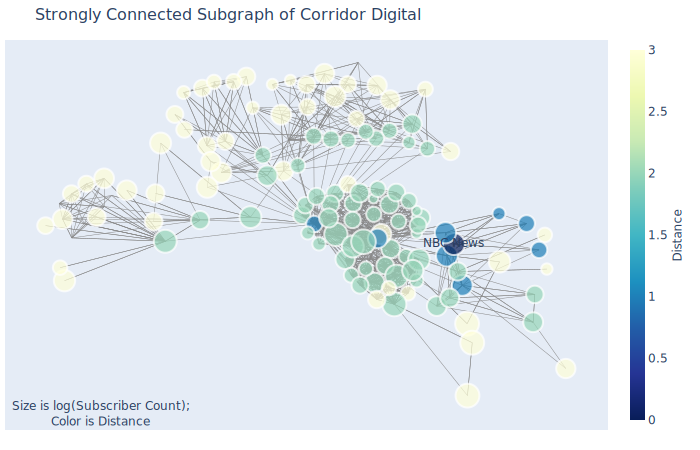

In [30]:
fig.show('svg')

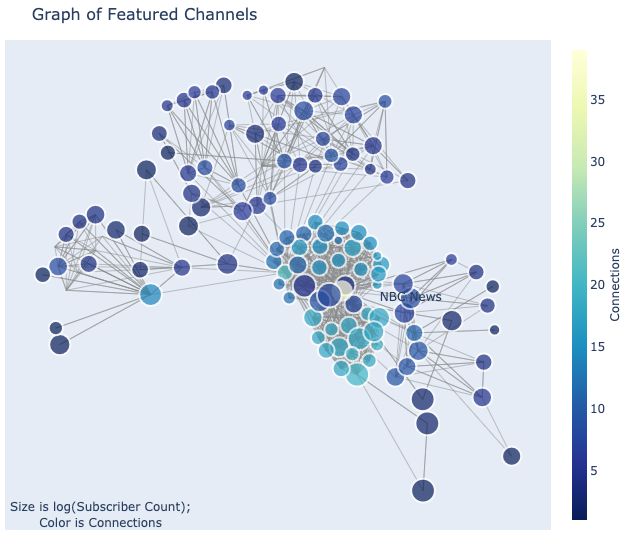

In [31]:
fig = network_graphs.plotly_network_graph(H, 'Connections')
fig

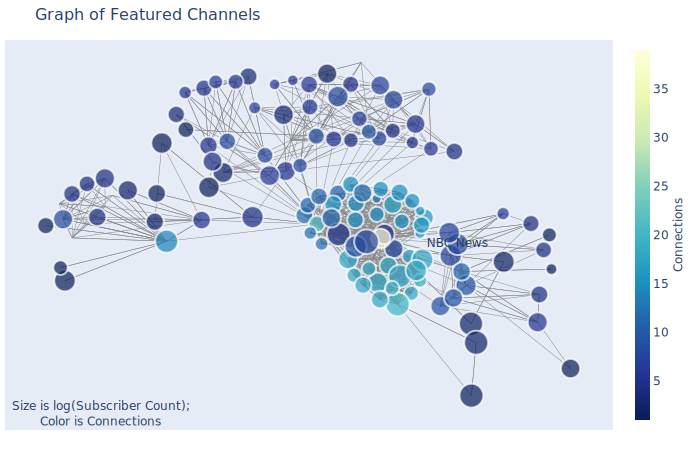

In [32]:
fig.show('svg')